In [1]:
import sys
import os
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

In [2]:
import pyaudio
import wave
import numpy as np
import tensorflow as tf
import seaborn as sns
import IPython
import matplotlib.pyplot as plt

from pydub import AudioSegment
from scipy.io import wavfile

from src.make_model import trigger_model
from src.trigger_make_dataset import transform_labels
from src.utils import *
from src.settings import *

/Users/az01640/Projets/multrigger-word/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/az01640/Projets/multrigger-word/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/az01640/Projets/multrigger-word/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/az01640/P

ModuleNotFoundError: No module named 'src.make_model'

In [ ]:
def load_model(weights_dir):
    """
    Load our seq_model with the latest checkpoint
    :param weights_dir: directory where we have our checkpoints from our training
    :return: our sequence model with weights
    """
    latest = tf.train.latest_checkpoint(str(weights_dir))

    model = trigger_model(input_shape=(TX, FX),
                      n_classes=N_CLASSES,
                      kernel_size=KERNEL_SIZE,
                      stride=STRIDE)

    model.load_weights(latest)

    return model

In [ ]:
model = load_model("../logs/trigger/checkpoints/")

In [3]:
positives, backgrounds = load_raw_audio()
map_dict = dict(enumerate(sorted(positives.keys()), 1))
map_dict[0] = "background"

NameError: name 'load_raw_audio' is not defined

In [49]:
def plot_predictions(wav_file, model):
    x = AudioSegment.from_wav(wav_file).set_frame_rate(FRAME_RATE).set_channels(1)
    x = match_target_amplitude(x, -20)
    x = np.array(x.get_array_of_samples())
    x = get_spectrogram(x)
    x = np.swapaxes(x, 0, 1)
    x = x[:TX,:]
    x = np.expand_dims(x, axis=0)
    y = model.predict(x)[0]
    sns.relplot(x='x', y='y', row='trigger', hue='label', 
                data=transform_labels(y, map_dict), 
                kind='line', legend="full")

In [50]:
# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    data2 = AudioSegment.from_wav(wav_file).set_frame_rate(FRAME_RATE).set_channels(1)
    return rate, data, data2

In [51]:
r, d, d2 = get_wav_info("test.wav")
type(d), type(d2)

(numpy.ndarray, pydub.audio_segment.AudioSegment)

In [52]:
def graph_spectrogram(wav_file, nfft=512, fs=2, noverlap=256):
    """
    Calculate and plot spectrogram for a wav audio file
    :param wav_file:
    :param nfft: Length of each window segment
    :param fs: Sampling frequencies
    :param noverlap: Overlap between windows
    :return:
    """
    rate, data = get_wav_info(wav_file)
    nchannels = data.ndim

    if nchannels > 1:
        data = data[:, 0]

    pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap=noverlap)

    return pxx

In [53]:
IPython.display.Audio(filename)

In [67]:
filenames = glob.glob("../data/interim/*.wav")
filenames

['../data/interim/dev-c256d425-f323-4e24-befa-249aa34528ad.wav',
 '../data/interim/dev-8f18b416-e0ac-4165-8883-e7c76dada3c3.wav',
 '../data/interim/val-ad9603e7-f984-4a8f-af0c-198088cbd49b.wav',
 '../data/interim/dev-47a3b0e3-ba8c-40de-9dc2-1c383a0c6bad.wav',
 '../data/interim/dev-2b9195e1-3ed1-4d35-8b82-df86dac2b9b9.wav']

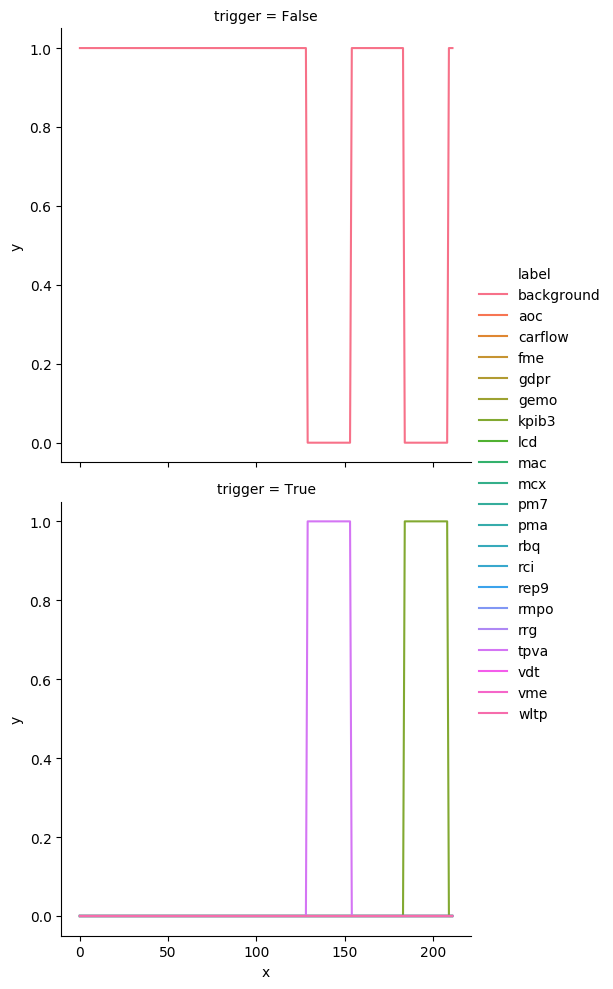

In [70]:
IPython.display.Image(filename.replace(".wav", ".png"))

In [83]:
filename = filenames[0]
print(filename)
IPython.display.Audio(filename)

../data/interim/dev-c256d425-f323-4e24-befa-249aa34528ad.wav


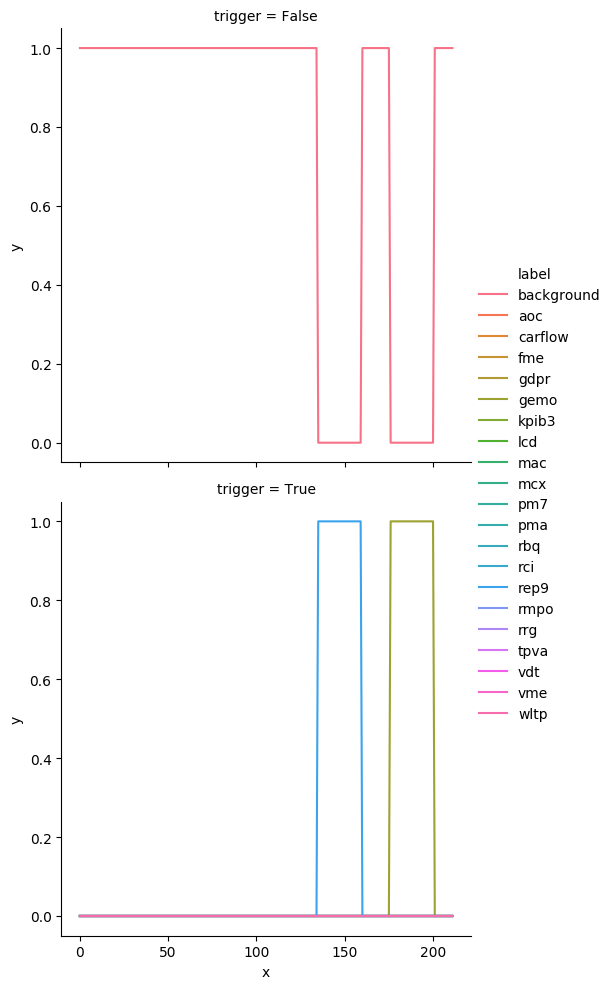

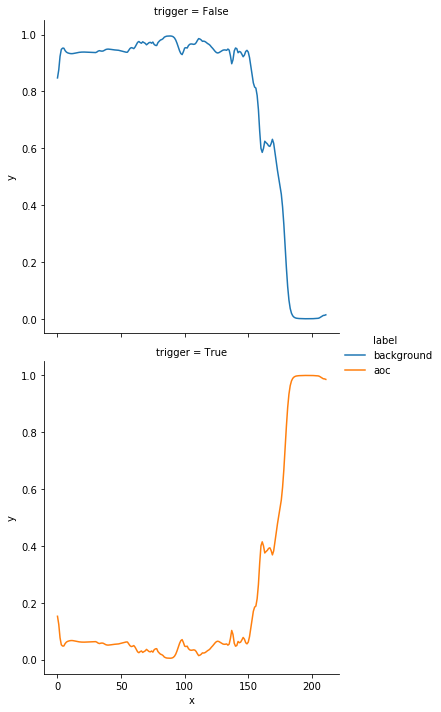

In [84]:
plot_predictions(filename, model)
IPython.display.Image(filename.replace(".wav", ".png"))

In [5]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 48000
CHUNK = 512
RECORD_SECONDS = 6
WAVE_OUTPUT_FILENAME = "test.wav"
 
audio = pyaudio.PyAudio()
 
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)

print("recording...")
frames = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print("finished recording")

# stop Recording
stream.stop_stream()
stream.close()
audio.terminate()

waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

recording...
finished recording


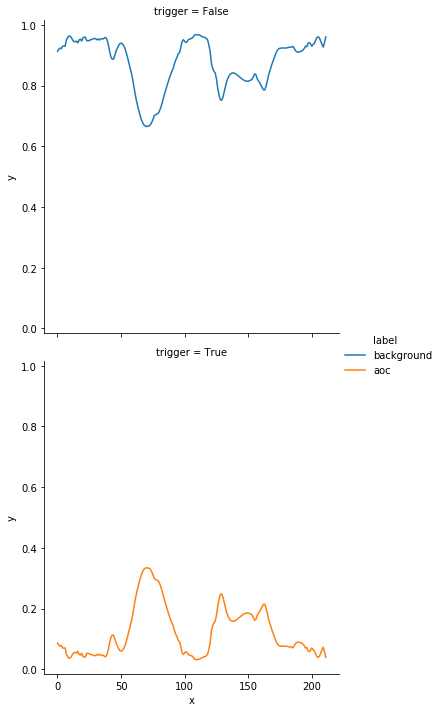

In [93]:
plot_predictions("test.wav", model)